# Tutorial 2: Poisson equation with multiple boundary conditions

In this tutorial, we will learn

   -  How to solve a simple PDE in Julia with Gridap
   -  How to load a discrete model (aka a FE mesh) from a file
   -  How to build a conforming Lagrangian FE space
   -  How to define the different terms in a weak form
   -  How to define inhomogeneous Neumann and Robin boundary conditions

We start from the following boundary problem:
find the scalar field $u$ such that

$$
\left\lbrace
\begin{aligned}
-\Delta u = f  \ &\text{in} \ \Omega,\\
u = g_D \ &\text{on}\ \Gamma_{\rm D},\\
\nabla u\cdot n = g_N \ &\text{on}\  \Gamma_{\rm N}.\\
\end{aligned}
\right.
$$
Here, $n$ denotes the outwards unit normal vector to the Neumann
boundary $\Gamma_{\rm N} = \{0\} \times [0,1] \cup \{1\} \times [0,1]$ and $\Gamma_D = \partial\Omega \setminus\Gamma_{\rm N}$. 

In this tutorial, we will again use the *method of manufactured solution* and construct two test problems, both posed on $\Omega = [0,1]^2$. 
For the two test problems (TP), we choose the exact solution $u_1$ and $u_2$ to be 
\begin{align*}
(TP1)\quad u_1(x,y) &= x + y,
\\
(TP2)\quad u_2(x,y) &= \sin(2 \pi x) \cos( 2 \pi y) + u_1(x, y).
\end{align*}






### Numerical scheme

 To solve this PDE, we use a conventional Galerkin finite element (FE) method with conforming Lagrangian FE spaces (see, e.g., [1] for specific details on this formulation). The weak form associated with this formulation is: 
 find $u\in V_g$ such that 
 $$ a(u,v) = l(v) $$
for all $v\in V_0$, where $V_g$ and $V_0$ are the subset of functions in $H^1(\Omega)$ that fulfill the Dirichlet boundary condition $g_D$ and $0$ respectively. 
 
### Task 1 

Find the correct bilinear and linear forms and write down correct test and trial function spaces.

**Solution.**
The bilinear and linear forms for this problems are
\begin{align*}
  a(u,v) &\doteq \int_{\Omega} \nabla v \cdot \nabla u \ {\rm d}\Omega, \\
   l(v) &\doteq \int_{\Omega} v\ f  \ {\rm  d}\Omega + \int_{\Gamma_{\rm N}} v\ h \ {\rm d}\Gamma_{\rm N}.
\end{align*}



The problem will be solved numerically by approximating the spaces $U_g$ and $V_0$ by their discrete counterparts associated with a FE mesh of the computational domain $\Omega$. As we have anticipated, we consider standard conforming Lagrangian FE spaces for this purpose.

### Task 2

Compute $f$, $g_D$ and $g_N$ for both test problems.

**Solution.**

## Define normal 
Let us define

\begin{align*}
n &= [\bar{n}, 0]^T \quad \text{where }
&\bar{n} = \begin{cases}
-1, \quad x= 0\\
 1, \quad x= 1\end{cases}
\end{align*}

#### TP1

\begin{align*}
f &=  - (\partial _{xx}  + \partial _{yy}   ) u_1 = 0
\\
g_N &=  \nabla u_1 \cdot n = \bar{n}
\end{align*}

#### TP2

\begin{align*}
f &=  - (\partial _{xx}  + \partial _{yy}   ) u_2 = 8 \pi^2 (sin(2\pi x) + cos(2\pi y))
\\
g_N &= \nabla u_1 \cdot n = 2\pi (cos(2\pi y )\cdot \bar{n} 
\end{align*}

## Using boundary tags
Next, we learn how to use and manipulate boundary tags. Typically when a mesh is generated, parts of the domain or boundary are tagged using some labels
in order to be able to distinguish them in the implementation of the numerical scheme.
In our case we have to distinguish between the Dirichlet boundary and the Neumann boundary as
the Dirichlet boundary condition need to be incorporated into the discrete function spaces while the Neumann boundary needs to be accounted for
in the definition of the linear form $l(\cdot)$.

Let's make again a triangular mesh for the unit square and plot it.

In [1]:
using Gridap

domain = (0, 1, 0, 1)
partition = nx, ny = 4, 4
model = CartesianDiscreteModel(domain, partition)


CartesianDiscreteModel()

Remember that for the plotting of $\Omega$, we need to create a `Triangulation` object from 
which we can plot using `GridapMakie`.

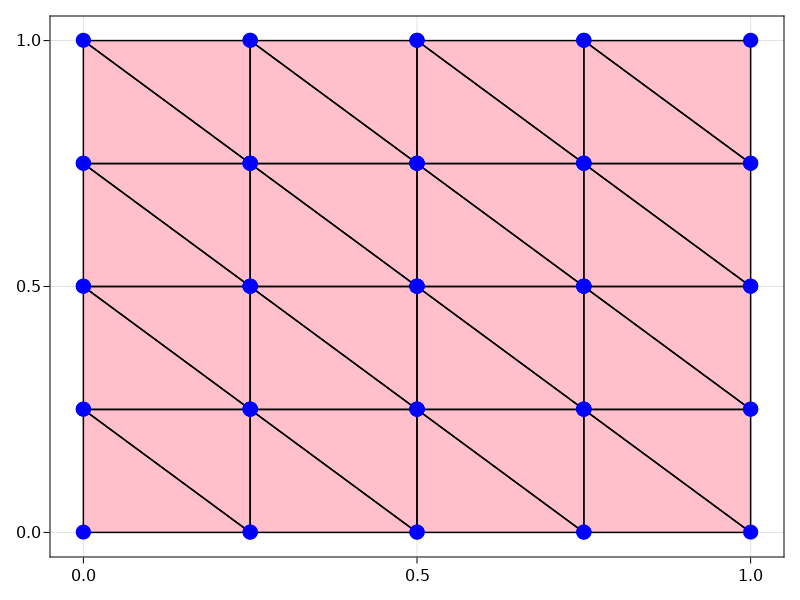

CairoScreen{Cairo.CairoSurfaceIOStream{UInt32}} with surface:
Cairo.CairoSurfaceIOStream{UInt32}(Ptr{Nothing} @0x000000000b8dbe60, 600.0, 450.0, IOBuffer(data=UInt8[...], readable=true, writable=true, seekable=true, append=false, size=0, maxsize=Inf, ptr=1, mark=-1))


In [2]:
using GridapMakie, CairoMakie, FileIO
Ω = Triangulation(model)
fig = plot(Ω)
wireframe!(Ω, color=:black)
scatter!(Ω, marker=:circle, markersize=20, color=:blue)
display(fig)
save("mesh_nx_$(nx)_ny_$(ny).svg", fig)

### Task 3
Let's visualize the boundary in the same manner, but use a `BoundaryTriangulation` instead of a `Triangulation` type.

**Solution.**

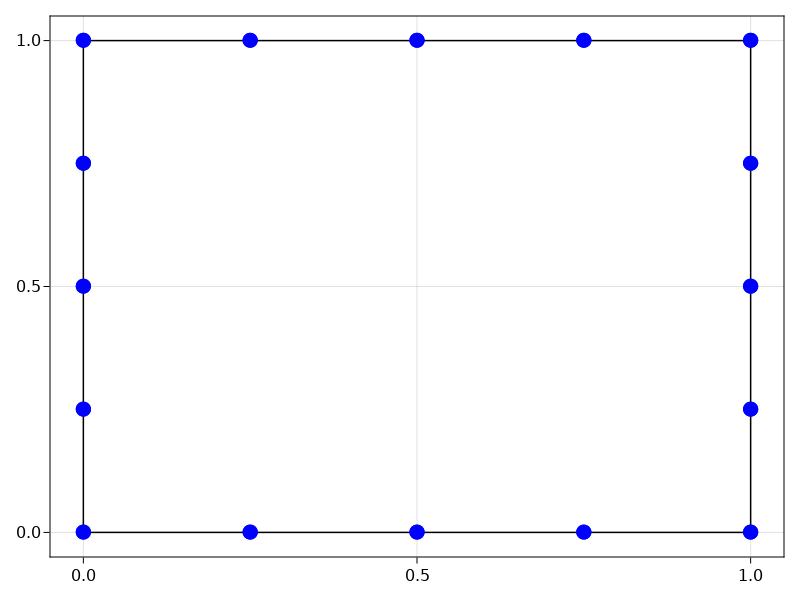

In [3]:
Γ = BoundaryTriangulation(model)
fig = plot(Γ)
wireframe!(Γ, color=:black)
scatter!(Γ, marker=:circle, markersize=20, color=:blue)
display(fig)

The discrete `model` we just generated also contains some extra labels which keep track of e.g. various sides of the model.
The `tags` or `labels` can be extracted using the `get_face_labeling` function like this:
 ```julia
labels = get_face_labeling(model)
 ```
 Afterwards, you either inspects in e.g. the workspace viewer in Visual Studio Code or 
 by simply accessing and printing its `tag_to_name` member. 
 Those tags related entities can also be easily visualized if you write the model
 to a vtk file and load it into Paraview.

In [4]:
labels = get_face_labeling(model)
labels.tag_to_name

10-element Vector{String}:
 "tag_1"
 "tag_2"
 "tag_3"
 "tag_4"
 "tag_5"
 "tag_6"
 "tag_7"
 "tag_8"
 "interior"
 "boundary"

The tags can be used to extract various parts of the boundary
using 
```julia
Γ_tag = BoundaryTriangulation(model, tags=["TAGNAME"])

```

### Task 4
Use that and visualize/plot each parts of the "boundary" which are associated with each tag.
Note that the "tag_1" to "tag_4" are actually tags associated with vertices and not with faces.


**Solution.**


### Task 5

Before we turn to the numerical solution of the full Poisson problem, we do a 
little preliminary exercise.

Integrate the function $g(x,y) = x + 2y$ 
separately over the left, right, bottom and top boundary of the boundary (check the results!).


### Task 6

Now, based on the previous tutorial and this tutorial, 
implemented a FEM solver. Use (TP1) and (TP2) to 
check your implementation, including a convergence test.

## Homework

Now following the steps in this tutorial, implement a FEM-based solver for the Poisson problem 
$$
\left\lbrace
\begin{aligned}
-\kappa \Delta u = f  \ &\text{in} \ \Omega,\\
u = g_D \ &\text{on}\ \Gamma_{\rm D},\\
\kappa \nabla u\cdot n = g_N \ &\text{on}\  \Gamma_{\rm N},\\
\kappa \nabla u\cdot n = \dfrac{1}{\epsilon}(g_R - u) \ &\text{on}\  \Gamma_{\rm R},\\
\end{aligned}
\right.
$$
where
$\Gamma_{\rm N} = \{0\} \times [0,1]$, 
$\Gamma_{\rm R} = \{1\} \times [0,1]$, 
and $\Gamma_D = \partial\Omega \setminus(\Gamma_{\rm N} \cup \Gamma_{\rm R})$. 

In particular this amounts to 
* determine the correct bilinear and linear forms
* use the method of manufactured solution to verify the correctness of your code. 
  Use at least one new, non-trivial manufactured solution.

We ask you to present your code/results in the tutorial session on Friday, 4th of March.

#### Happy coding! 